# Unsupervised Learning

In this section we begin exploring some unsupervised learning concepts.

We have two main goals from this section:
1. Feature Importance Determination
2. Identifiying Similiar Player Profiles of athletes with and without NIL Evaluations

In [1]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplcursors

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Since our pipeline is not up and running yet, let's just import the traintestsplit function
from python_scripts.traintestsplit import custom_train_test_split

In [3]:
# Read in the cleaned CSV  for football
df = pd.read_csv("cleaned_files/basketball_clean_unsupervised.csv")
df = df.set_index('NAME')
X_train = df.drop(columns='NILVAL_LONG_USD')
# Since we cannot work with any NAN values and we are in the process of data cleaning we are going to ignore these values for now...
# dfClean = df.dropna()
# print(dfClean.shape)

In [4]:
# One player has a height that is 'nan' -- this is a bug that should be fixed
X_train = X_train.dropna()

In [5]:
# X_train, y_train, X_valid, y_valid, X_test, y_test = custom_train_test_split(df)
# print(X_train.shape)
# print(y_train.shape)

## Feature Importance Determination

The outputs of this feature importance determination will be crucial in plotting and visualizing things from the KMeans Effort Below!

Since our goal is to reduce our problem down for visualization purposes we are going to explore options in which the number of components is either 2 or 3 although a further analysis regarding the importance of features should also be performed.

It is sometimes good for very large, high-dimensional datasets to use PCA and then apply t-SNE/UMAP after!

In [6]:
def dimReductionPrep(X_train):
    """
        :: Input(s) ::
            X_train - the training feature dataset
        :: Output(s) ::
            X_train_Reduced - the training feature dataset with only numeric columns included
        :: Explaination of Function ::
            Lots of unsupervised functions require that data be mean centered and normalized. We cannot mean center and normalize non-numerica data so this function helps
            take the output from "traintestsplit" and reduce the columns down to only those with numeric features
    """

    cols2Keep = ['HEIGHT_IN', 'WEIGHT_LBS', 'SKILL', 'COLLDIST_MI',
                 'NUMOFF', 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG',
                 'ClassificationCode', 'REV_MEN', 'EXP_MEN']
    
    X_train_Reduced = X_train[cols2Keep]

    return X_train_Reduced

#### Principal Components Analysis (PCA)

- A deviation from PCA would be to perform information gain (IG) techniques for each column in our feature space against the ground truth label (the target). This method still suffers from information loss however.
    - A method of creating a new feature which is linearly independent from other features. You would take k PC's which is assumed to be < # features
    - IF YOU ARE USING PCA OR ANY METHOD TO REDUCE THE NUMBER OF FEATURES YOU MUST APPLY **AFTER** TRAIN/TEST/SPLIT TO AVOID DATA LEAKAGE!!!!!!!!!
    - Creating a scatter plot post PCA is neat. It is also cool to look at a heatmap of the original features and the principal components
    - BIPLOTS:
        - combines a score plot and a loadings plot in a single graph
        - Basically you plot all of your data on the pricipal components (lets say 2 in this case) and then you can plot the ORIGINAL features in this space! The angle between vectors in the original feature space can tell us correlation!
    - SCREE PLOTS:
        - Plots the eigenvalues from PCA
        - pca.explained_variance_ from the output of the PCA var
        - Kaiser Heursitic -- if the elbow is tough to find, keep all eigenvalues with a score of at least 1
    - If the number of principal components is too big then you know that some kind of non-linear technique like kernel PCA might be required

In [7]:
def custom_PCA_Scree(X_train_Reduced, n_comp=8, threshold=0.8):
    """
        :: Input(s) ::
            X_train_Reduced - training data with only numeric columns
            n_comp - the number of components that we are going to extract with PCA
            threshold - the amount of explained variance that the user would like to be captured by the minimum number of pricipal components
        :: Output(s) ::
            None
        :: Explaination of Function ::
        This fucntion performs Principal Components Analysis (PCA) on the training data that was provided by "traintestsplit.ipynb".
        The goal here is two fold:
            1. Generate a Scree Plot that incorporates an explained varaince ratio
            2. Help the user determine the minumum number of components in order to consider utilizing PCA
    """

    # Normalize the data prior to performing PCA!
    # This is crucial as we do not want magnitude of a feature to play a role
    X_train_Norm = StandardScaler().fit_transform(X_train_Reduced)
    pca = PCA(n_components=n_comp)
    X_pca = pca.fit_transform(X_train_Norm)

    # Since the n_comp is dynamic, we need a dynamic way to show the PC's
    PCs = []
    for i in range(n_comp):
        PCs.append('PC{}'.format(i+1))

    # Generate the Cumulative Sum of Explained Variance
    dfCumul = pd.DataFrame({'explained_var_ratio': pca.explained_variance_ratio_,
                            'PC': PCs})
    
    dfCumul['cumulative_variance'] = dfCumul['explained_var_ratio'].cumsum()
    threshold = threshold
    n_components_thresh = np.argmax(dfCumul['cumulative_variance'] >= threshold) + 1

    # Generate the Scree Plot
    dfScree = pd.DataFrame({'eigenvalue': np.sqrt(pca.explained_variance_),
                            'PC': PCs})
    
    plt.figure(figsize=(8,6))
    plt.plot(dfScree['PC'],
             dfScree['eigenvalue'],
             color='b',
             marker='o',
             linestyle='--')
    plt.xlabel('Principal Component (PC)')
    plt.ylabel('Eigenvalue')
    plt.title('Scree Plot')

    plt.axvline(dfScree['PC'][n_components_thresh - 1],
                color='red',
                label="At least {:.0f}% of Varaince Accounted for with {} PC's".format(threshold*100, n_components_thresh))
    
    plt.legend(loc='lower left')
    plt.show()

    return None

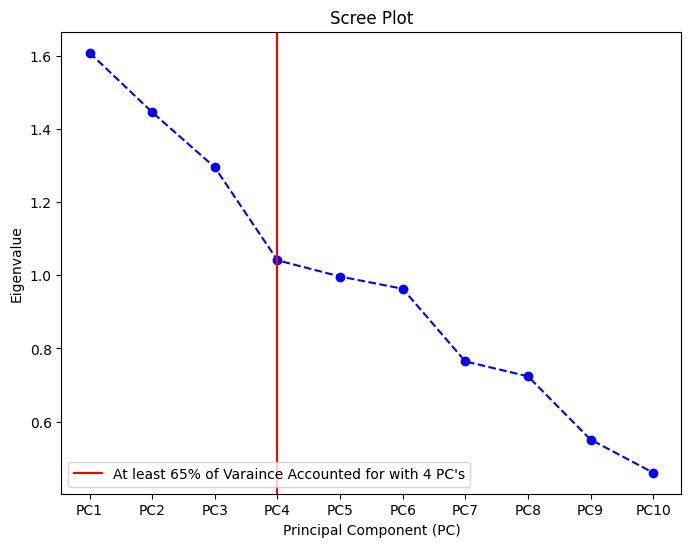

In [34]:
custom_PCA_Scree(dimReductionPrep(X_train), n_comp=10, threshold=0.65)

In [9]:
def custom_BiPlot(X_train_Reduced):
    """
        :: Input(s) ::
            X_train_Reduced - training data with only numeric columns
        :: Output(s) ::
            None
        :: Explaination of Function ::
            This function creates a biplot from the PCA solution.
            The biplot shows the two principal components with the biggest eigenvalues (PC's that explain the most variance in the data)
            and plots the data as well as the original features as vectors in this space
    """

    # Normalize the data prior to performing PCA!
    # This is crucial as we do not want magnitude of a feature to play a role
    X_train_Norm = StandardScaler().fit_transform(X_train_Reduced)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_train_Norm)

    # The 'scores' are the individual points that make up the scatterplot in 2 dimensions
    # X_pca

    # The 'vectors' are the loadings that help map the original features onto our scatterplot
    # The COSINE of the angle between two variable markers is the coefficent of correlation between those variables!
    # If one of your vectors follows the x or y axis then you can correlate the variable marker and the PC!
    # You can take the dot product of your point in 2D PC Space with each of these variable markers to "reconstruct" in the original feature space!
    
    # X = pca.components_[i,0]
    # Y = pca.components_[i,1]
    
    coeff = np.transpose(pca.components_[0:2, :])
    maxdim = 8

    xs = X_pca[:,0]
    ys = X_pca[:,1]

    n = min(coeff.shape[0], maxdim)
    scalex = 2.0 / (xs.max() - xs.min())
    scaley = 2.0 / (ys.max() - ys.min())
    text_scale_factor = 1.5

    plt.figure(figsize=(10, 12))
    plt.scatter(xs * scalex, ys * scaley, s=5)

    for i in range(n):
        plt.arrow(0,0,coeff[i,0],coeff[i,1],color='red',alpha=0.5)
        plt.text(
            coeff[i,0] * text_scale_factor,
            coeff[i,1],
            X_train_Reduced.columns[i],
            color='g',
            ha='center',
            va='center'
        )
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid()
    plt.tight_layout()
    plt.show()
    return None

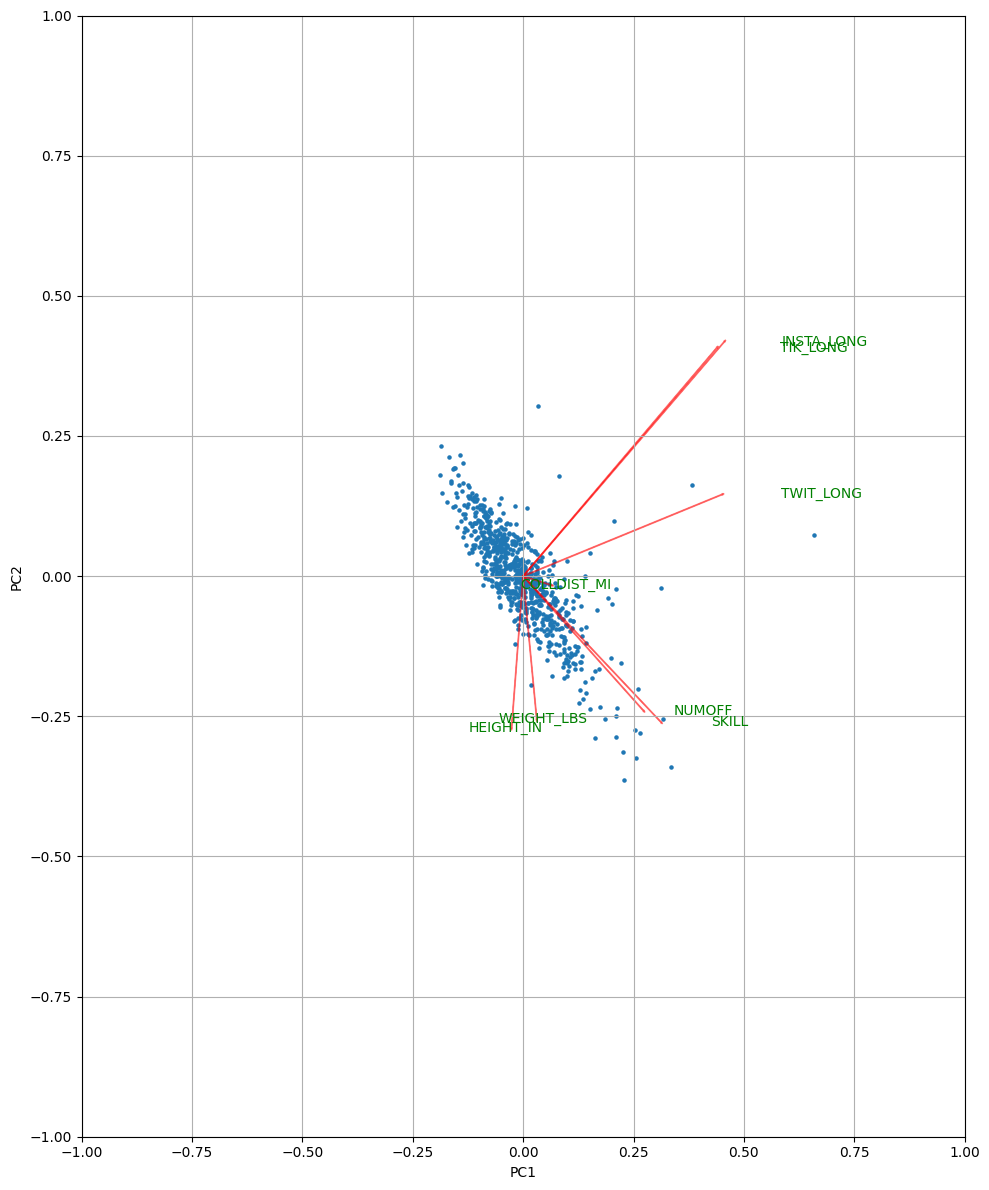

In [10]:
custom_BiPlot(dimReductionPrep(X_train))

#### Multidimensional Scaling (MDS)

- Distance preserving low-dimensional projection
- Locally influenced
- If clusters are far apart in the OG data, then they will be far apart in the MDS projection
- weights can be introduced to handle missing data in MDS! We have lots of missing data in this project...

In [15]:
def custom_MDS(X_train_Reduced):
    """
        :: Input(s) ::
            X_train_Reduced - training data with only numeric columns
            y_train - the labelled training data which assigns clusters... Could make this dynamic based on whether or not y_train exists?
            n_comp - the number of components that will be graphed for the scatterplot
        :: Output(s) ::
            None
        :: Explaination of Function ::
            This function helps plot the Multidimensional Scaling (MDS) feature space to help us understand
            how data could be preserved using MDS. MDS is a method that helps to retain local distance whereas PCA performs
            global distances.
    """
    # Normalize the data prior to performing MDS!
    # This is crucial as we do not want magnitude of a feature to play a role
    X_train_Norm = StandardScaler().fit_transform(X_train_Reduced)
    mds = MDS(normalized_stress='auto')
    X_mds = mds.fit_transform(X_train_Norm)

    # Bin the output values to help with clusters
    # https://taxfoundation.org/data/all/federal/2023-tax-brackets/
    # bins = [0, 11000, 44725, 95375, 182100, 231250, 578125, np.inf]
    # labels = ['10% Tax Bracket', '12% Tax Bracket', '22% Tax Bracket',
    #           '24% Tax Bracket','32% Tax Bracket', '35% Tax Bracket', '37% Tax Bracket']
    # y_train_cat = pd.cut(y_train, bins=bins, labels=labels)

    plt.figure(figsize=(8,6))
    plt.scatter(X_mds[:,0],
                X_mds[:,1])
    
    # mplcursors.cursor(scatter, hover=True).connect(
    #     "add", lambda sel: sel.annotation.set_text(X_mds.index[sel.target.index]))
    
    plt.title('MDS Scatter Plot w/ Categorical Clusters')
    plt.xlabel("MDS Dimension 1")
    plt.ylabel("MDS Dimension 2")

    for i, txt in enumerate(df.index):
        if i < len(X_mds):  # Check if i is within bounds
            plt.annotate(txt, (X_mds[:,0][i]+0.3, X_mds[:,1][i]))
    plt.show()

    return None

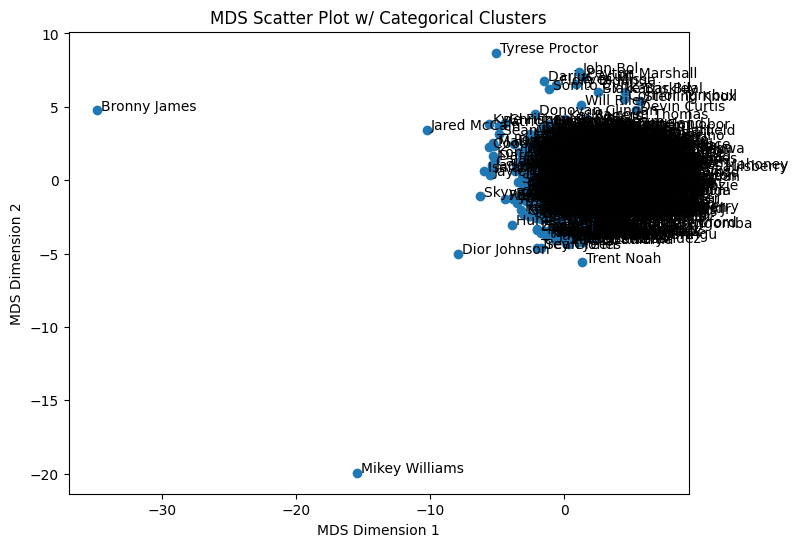

In [16]:
custom_MDS(dimReductionPrep(X_train))

#### t-Distributed Stochastic Neighbor Embedding (t-SNE)

- Finds a low-dim output
    - Preserves similiaries in high-dim data
    - It is focused on preserving LOCAL DISTANCES between neighbors, not so much global structure
    - Perplexity is the key parameter
        - Experiment with multiple values here!
    - Can give different output everytime it runs!

In [ ]:
# ==== tSNE =====
from sklearn.manifold import TSNE
# tsne = TSNE(random_state=0)
# X_tsne = tsne.fit_transform(X_norm)

# plot(X_tsne, output, [NAMES_OF_CLUSTERS])
# ===============

#### Uniform Manifold Approximation & Projection (UMAP)

- Similiar to t-SNE --> Preserves local neighborhood structure
- But it also preserves some global structure too!
- It is a useful technique for plotting AS WELL AS clustering whereas t-SNE should not be used in clustering...

## Similiar Player Profiles

Notes regarding KMeans clustering:
- Different intializations can result in different solutions. Performing multiple runs is a good idea.
    - Be careful about where you start
    - Could place the first one randomly and the next one could be as far away as possible
- Centroid is typically the mean of the points in the cluster.
    - This works only when the values are continuous in nature. K-Medoid can be used if non-continuous columns are used.
- "Closeness" can take the form of Euclidean Distance, Cosine Similiarity, Correlation, etc

KMeans works well on simple clusters that are similiar in size, well seperated, and globular. Complex shapes... not so much...

##### Visualization Tips

When it comes to plotting this data it will be difficult to use normal ol KMeans because our data has lots of columns.
- PCA would work to reduce the data down to maybe two principal components
- t-SNE would also work to reduce the visualization down to something that is more interpretable

In [22]:
def custom_KMeans_Scree(X_train, max_clusters=8, RANDOM_STATE=0):
    """
        :: Input(s) ::
            X_train - training data
        :: Output(s) ::
            A Scree Plot
        :: Explaination of Function ::
            This function can be used to help the user determine the appropriate number of clusters to choose for this problem
    """

    # Remember that X_train does not contain any NIL information, that is perfectly okay because we are interested in all athletes
    # regardless of their NIL evaluation

    # We may want to normalize the features we have in some way, shape, or form...
    X_normalized = StandardScaler().fit_transform(X_train)

    # Elbow Plot Setup
    upperBound = max_clusters + 1
    scores = []
    centers = list(range(1,upperBound))
    for cluster in range(1,upperBound):
        kmeans = KMeans(n_clusters=cluster,
                        random_state=RANDOM_STATE)
        kmeans.fit(X_normalized)
        scores.append(np.abs(kmeans.score(X_normalized)))
    
    plt.figure(figsize=(8,6))
    plt.plot(centers, scores, linestyle='--', marker='o', color='b')
    plt.xlabel('# of Clusters')
    plt.ylabel('Sum of Square Errors (SSE)')
    plt.title('SSE vs # of Clusters')

    return None

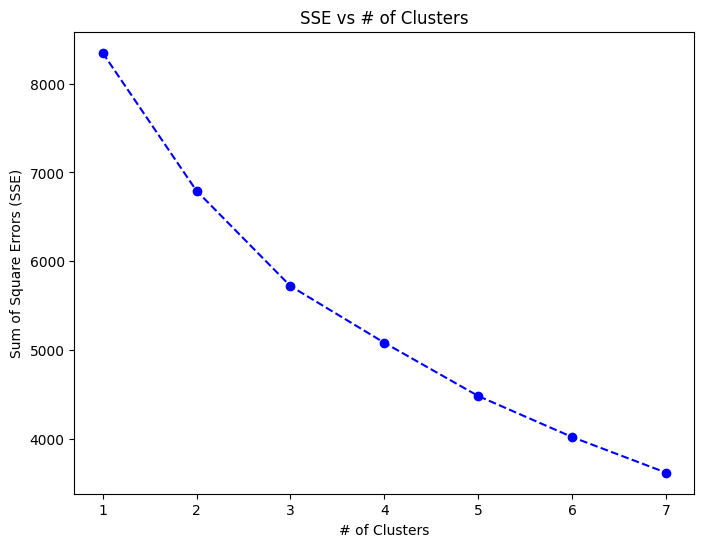

In [23]:
custom_KMeans_Scree(dimReductionPrep(X_train), max_clusters=7)

In [32]:
def custom_KMeans(X_train, num_clusters=3, RANDOM_STATE=0):
    """
        :: Input(s) ::
            X_train - Can only have 2 or 3 features for plotting purposes!
            num_clusters - the number of clusters that KMeans will divide the data up into
            RANDOM_STATE - the random state for this function (for repeatability)
        :: Output(s) ::
            A KMeans cluster plot
        :: Explaination of Function ::
            This function is supposed to be used ~after~ custom_KMeans_Scree after the user has determined the appropriate number of clusters to plot
    """
    # We may want to normalize the features we have in some way, shape, or form...
    X_normalized = StandardScaler().fit_transform(X_train)

    kmeans = KMeans(n_clusters=num_clusters,
                    random_state=RANDOM_STATE)
    model = kmeans.fit(X_normalized)
    labels = model.predict(X_normalized)

    plt.figure(figsize=(8,6))

    if X_normalized.shape[-1] == 3:
        ax = plt.axes(projection='3d')
        ax.grid()
        scatter = ax.scatter(X_normalized[:,0],
                             X_normalized[:,1],
                             X_normalized[:,2],
                             c=labels,
                             label=labels)
        ax.set_title("KMeans Cluster Plot")
        ax.set_xlabel('{}'.format(X_train.columns[0]), labelpad=5)
        ax.set_ylabel('{}'.format(X_train.columns[1]), labelpad=5)
        ax.set_zlabel('{}'.format(X_train.columns[2]), labelpad=5)
    elif X_normalized.shape[-1] == 2:
        scatter = plt.scatter(X_normalized[:,0],
                              X_normalized[:,1],
                              c=labels,
                              label=labels)
        plt.title('KMeans Cluster Plot')
        plt.xlabel('{}'.format(X_train.columns[0]))
        plt.xlabel('{}'.format(X_train.columns[1]))
    else:
        print("X_train has too many features... can only plot data with 2 or 3 features!")
        return None
    
    legend_entries = []
    for cluster_label in range(num_clusters):
        legend_entry = f'Cluster {cluster_label}'
        legend_entries.append(legend_entry)
    
    plt.legend(handles=scatter.legend_elements()[0], labels=legend_entries, title="Cluster")

    # Plot the names of some of the players in a cluster!
    # dimReductionPrep(X_train)[['COLLDIST_MI', 'SKILL']]
    for i, label in enumerate(labels):
        if label == 2:
            plt.annotate(df.index[i], (X_normalized[:,0][i]+0.3, X_normalized[:,1][i]))
    
    plt.show()

    return None

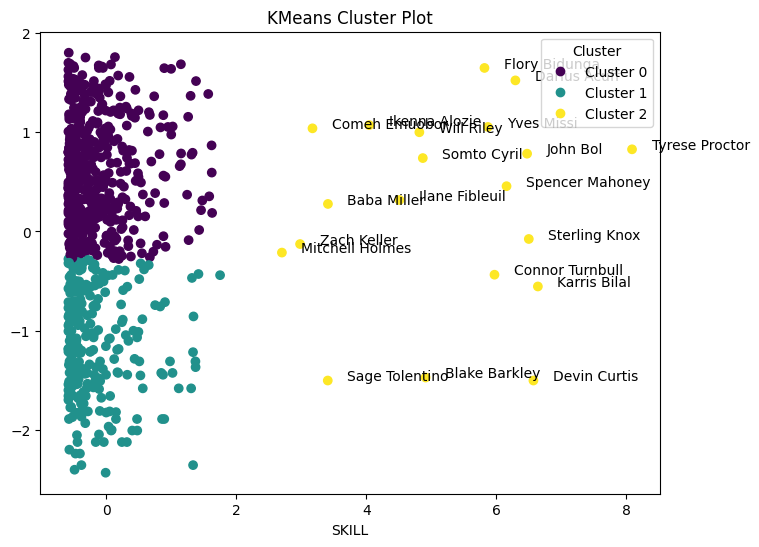

In [33]:
custom_KMeans(dimReductionPrep(X_train)[['COLLDIST_MI', 'SKILL']], num_clusters=3)

I would then like to implement:
1. Some kind of hierarchical clustering method (cluster.Agglo...) which could output a dendrogram
2. DBSCAN which could output a really nice plot that can handle some complicated data